## *Power Consumption*
ML Time Series Forecasting

In [16]:
import pandas as pd
import numpy as np
import sklearn.model_selection as model

Sort Entries

In [17]:
def sort_energy_data(file_path):
    """
    Read and sort energy consumption data by datetime
    
    Parameters:
    file_path (str): Path to the CSV file containing energy data
    
    Returns:
    pandas.DataFrame: Sorted DataFrame with datetime index
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert datetime column to pandas datetime
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    # Sort by datetime
    df_sorted = df.sort_values('Datetime')
    
    # Optionally set datetime as index
    df_sorted = df_sorted.set_index('Datetime')
    
    return df_sorted

# Example usage
"""
# Assuming your data is in 'energy_data.csv':
data = sort_energy_data('energy_data.csv')

# To save the sorted data to a new CSV file:
data.to_csv('sorted_energy_data.csv')

# To view first few rows:
print(data.head())
"""

"\n# Assuming your data is in 'energy_data.csv':\ndata = sort_energy_data('energy_data.csv')\n\n# To save the sorted data to a new CSV file:\ndata.to_csv('sorted_energy_data.csv')\n\n# To view first few rows:\nprint(data.head())\n"

In [18]:
# data=sort_energy_data(dataset)
# data.to_csv("cleaned_NI.csv")
dataset="cleaned_NI.csv"

### EDA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58450 entries, 2004-05-01 01:00:00 to 2011-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NI_MW   58450 non-null  float64
dtypes: float64(1)
memory usage: 913.3 KB
None
              NI_MW
count  58450.000000
mean   11701.682943
std     2371.498701
min     7003.000000
25%     9954.000000
50%    11521.000000
75%    12896.750000
max    23631.000000


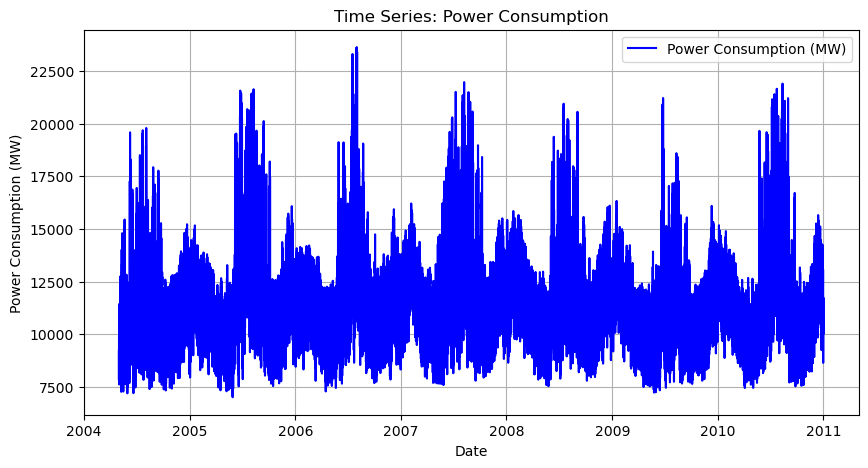

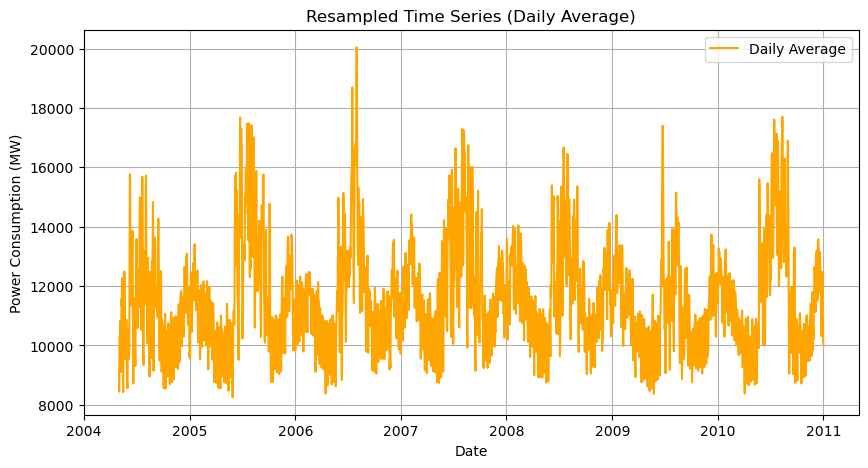

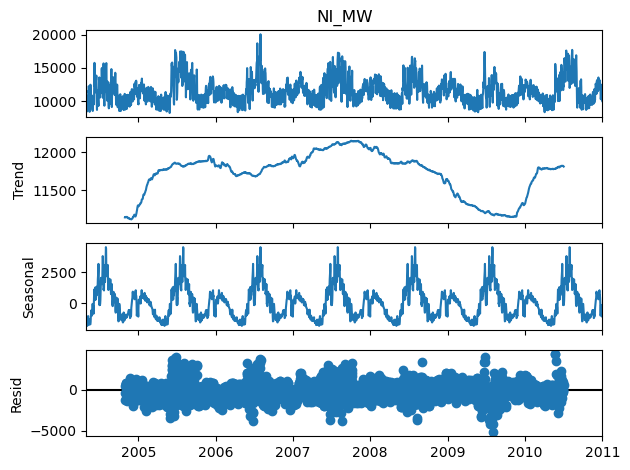

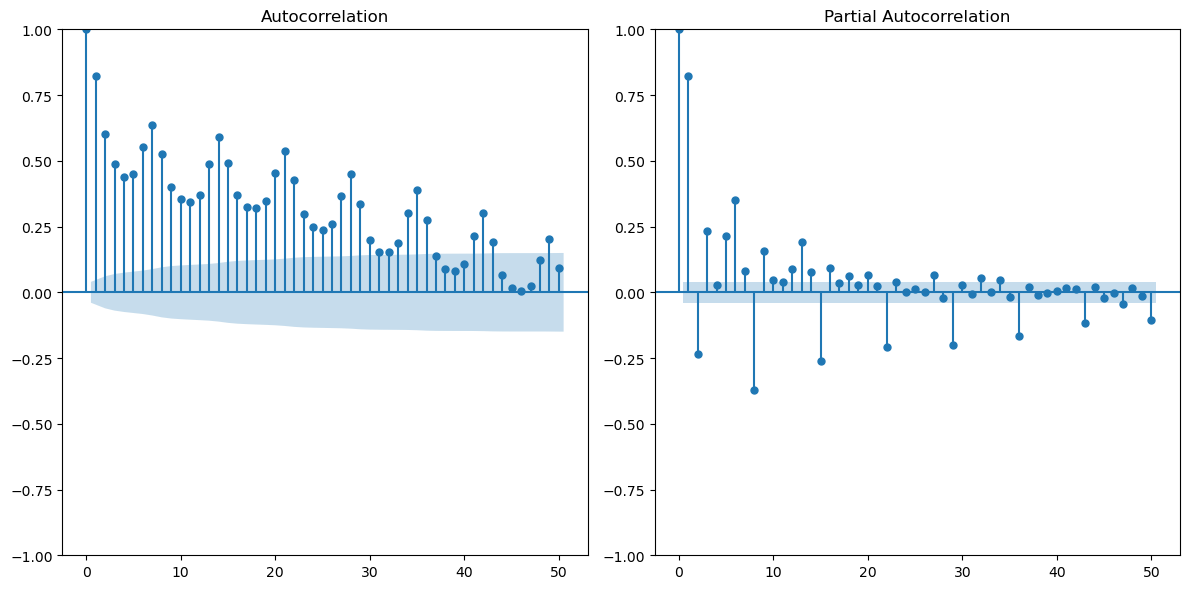

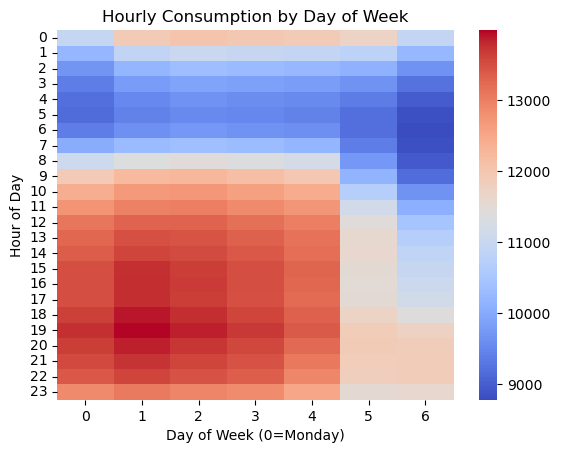

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
data = pd.read_csv(dataset, parse_dates=['Datetime'], index_col='Datetime')

# Display basic info
print(data.info())
print(data.describe())

# Sort data by datetime
data = data.sort_index()

# Plot the raw data
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['NI_MW'], label='Power Consumption (MW)', color='blue')
plt.title('Time Series: Power Consumption')
plt.xlabel('Date')
plt.ylabel('Power Consumption (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Resample data (daily average for clarity in long-term trends)
daily_data = data['NI_MW'].resample('D').mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_data.index, daily_data, label='Daily Average', color='orange')
plt.title('Resampled Time Series (Daily Average)')
plt.xlabel('Date')
plt.ylabel('Power Consumption (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Decomposition to understand trends and seasonality
decomposition = seasonal_decompose(daily_data.dropna(), model='additive', period=365)
decomposition.plot()
plt.show()

# Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(daily_data.dropna(), ax=plt.gca(), lags=50, title='Autocorrelation')
plt.subplot(122)
plot_pacf(daily_data.dropna(), ax=plt.gca(), lags=50, title='Partial Autocorrelation')
plt.tight_layout()
plt.show()

# Heatmap for seasonality detection (hourly, daily, or monthly trends)
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

pivot_table = data.pivot_table(index='hour', columns='day_of_week', values='NI_MW', aggfunc='mean')
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title('Hourly Consumption by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Hour of Day')
plt.show()

# ML/DL Model Selection Notes:
# - Use ARIMA or SARIMA for short-term univariate forecasts.
# - Consider LSTM/GRU for longer-term trends and nonlinear patterns.
# - For multivariate forecasts, explore VAR or advanced DL models (e.g., Seq2Seq, Transformer).

In [21]:
# Define the forecast horizon (1 year)
test_period = 365 * 24  # Assuming hourly data, adjust if different frequency

# Split data into training and testing sets
train_data = data.iloc[:-test_period]
test_data = data.iloc[-test_period:]

In [7]:
# from prophet import Prophet
# df = train_data.reset_index().rename(columns={'Datetime': 'ds', 'NI_MW': 'y'})
# model = Prophet()
# model.fit(df)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [23]:

# Create lag features for supervised learning
def create_features(df, target_column, lags):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    return df

# Apply feature engineering
lags = 24  # Use the last 24 hours as features
train_data = create_features(train_data, 'NI_MW', lags).dropna()
test_data = create_features(test_data, 'NI_MW', lags).dropna()

# Split into features and target
X_train = train_data.drop(columns=['NI_MW'])
y_train = train_data['NI_MW']
X_test = test_data.drop(columns=['NI_MW'])
y_test = test_data['NI_MW']


In [24]:

# Normalize data for DL models
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fix: Drop rows to ensure divisibility by lags
n_lags = 24  # Number of hourly lags
train_rows = len(X_train_scaled) - (len(X_train_scaled) % n_lags)
test_rows = len(X_test_scaled) - (len(X_test_scaled) % n_lags)

# Reshape train and test datasets
X_train_lstm = X_train_scaled[:train_rows].reshape(-1, n_lags, 1)
X_test_lstm = X_test_scaled[:test_rows].reshape(-1, n_lags, 1)

# Adjust target variables accordingly
y_train_lstm = y_train[:train_rows]
y_test_lstm = y_test[:test_rows]


In [25]:
from sklearn.metrics import mean_squared_log_error,r2_score

# Define a function to evaluate models
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    r2 = r2_score(y_test, predictions)
    smape = 100 * np.mean(2 * np.abs(predictions - y_test) / (np.abs(y_test) + np.abs(predictions)))
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}, sMAPE: {smape:.2f}%")
    return predictions

## Random Forests

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("Step 1: Loading and preprocessing data...")  # Progress loader

# Load and preprocess the data
data = pd.read_csv(dataset, parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()  # Ensure data is sorted by time

print("Step 2: Creating lag features and target variable...")  # Progress loader

# Create lag features for supervised learning
def create_features_and_target(df, target_column, lags):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    # Target is the next 24 hours (for 1 day forecasting)
    df['target'] = df[target_column].shift(-24)
    return df

# Add time-based features (hour, day of week)
def add_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    return df

# Feature Engineering
lags = 24  # Last 24 hours as input
data = create_features_and_target(data, 'NI_MW', lags)
data = add_time_features(data).dropna()

print("Step 3: Splitting data into training and testing sets...")  # Progress loader

# Train-test split
test_period = 365 * 24  # Last 1 year for testing
train_data = data.iloc[:-test_period]
test_data = data.iloc[-test_period:]

X_train = train_data.drop(columns=['NI_MW', 'target'])
y_train = train_data['target']
X_test = test_data.drop(columns=['NI_MW', 'target'])
y_test = test_data['target']

print(f"Training data size: {X_train.shape[0]} rows")
print(f"Testing data size: {X_test.shape[0]} rows")


Step 1: Loading and preprocessing data...
Step 2: Creating lag features and target variable...
Step 3: Splitting data into training and testing sets...
Training data size: 49642 rows
Testing data size: 8760 rows


Step 4: Training the Random Forest model...
Model training complete!
Step 5: Generating predictions...
Step 6: Evaluating the model...
Evaluation Metrics -> RMSE: 942.64, MAE: 597.28
Step 7: Visualizing predictions...


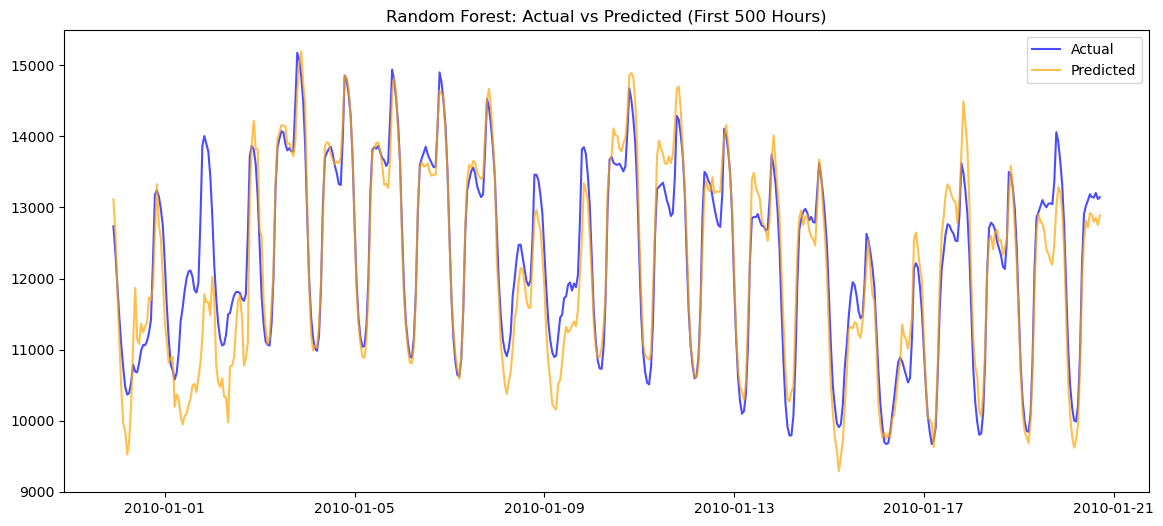

Visualization complete!


In [34]:

print("Step 4: Training the Random Forest model...")  # Progress loader
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Model training complete!")

# Predictions
print("Step 5: Generating predictions...")  # Progress loader
rf_predictions = rf_model.predict(X_test)

print("Step 6: Evaluating the model...")  # Progress loader
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
mae = mean_absolute_error(y_test, rf_predictions)
print(f"Evaluation Metrics -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print("Step 7: Visualizing predictions...")  # Progress loader
# Plot Results
plt.figure(figsize=(14, 6))
plt.plot(y_test.index[:500], y_test[:500], label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index[:500], rf_predictions[:500], label='Predicted', color='orange', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted (First 500 Hours)')
plt.legend()
plt.show()

print("Visualization complete!")

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [35]:
mape = mean_absolute_percentage_error(y_test, rf_predictions)
print(f"MAPE: {mape:.2f}%")

MAPE: 4.75%


In [ ]:
evaluate_model(rf_model,X_test,y_test)

RMSE: 942.64, MAE: 597.28, MAPE: 4.75%, R2: 0.86, sMAPE: 4.74%


array([13113.72, 12658.38, 11830.44, ..., 11933.32, 11369.51, 10912.66])

Step 4: Training the XGBoost model...
XGBoost model training complete!
Step 5: Generating predictions with XGBoost...
Step 6: Evaluating the XGBoost model...
XGBoost Evaluation Metrics -> RMSE: 924.02, MAE: 595.93
Step 7: Visualizing predictions (XGBoost)...


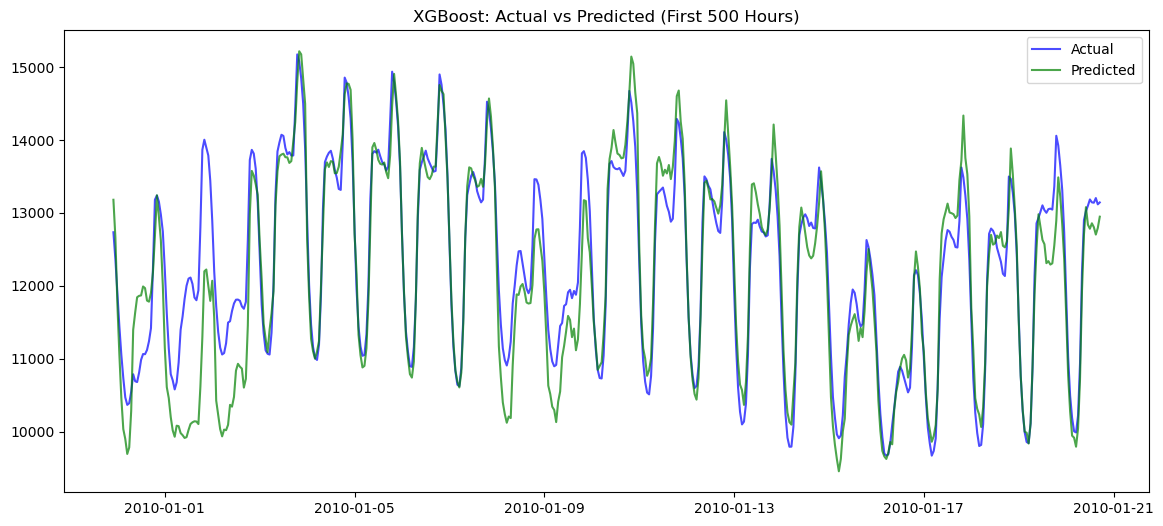

RMSE: 924.02, MAE: 595.93, MAPE: 4.76%, R2: 0.86, sMAPE: 4.76%


array([13180.494, 12659.937, 11754.123, ..., 12226.901, 11619.744,
       10684.392], dtype=float32)

Step 4: Scaling data for Fully Connected Neural Network...
Step 5: Building the Fully Connected Neural Network...
Step 6: Training the Fully Connected Neural Network...
Epoch 1/20


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(8760,)

MAPE: 7.50%


In [ ]:
# from tensorflow.keras.models import model_from_json
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Load model configuration from JSON
# with open('t_model.keras/config.json', 'r') as config_file:
#     model_json = config_file.read()

# # Recreate the model architecture
# best_transformer_model = model_from_json(model_json)

# # Load the pre-trained weights
# best_transformer_model.load_weights('t_model.keras/model.weights.h5')

# # Recreate the optimizer (e.g., Adam)
# optimizer = Adam()

# # Recompile the model with the correct loss function and metrics
# best_transformer_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# # Set up callbacks for early stopping and model checkpointing
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=10, 
#     restore_best_weights=True, 
#     verbose=1
# )

# model_checkpoint = ModelCheckpoint(
#     'best_transformer_model1.keras', 
#     monitor='val_loss', 
#     save_best_only=True, 
#     verbose=1
# )

# # Train the model
# history = best_transformer_model.fit(
#     X_train, y_train,
#     epochs=20,  # Train for up to 20 epochs
#     batch_size=32,
#     validation_data=(j, b),  # Ensure you split your training data into training and validation sets
#     callbacks=[early_stopping, model_checkpoint],
#     verbose=1
# )

# # Evaluate the model on the test set
# test_loss, test_mae = best_transformer_model.evaluate(X_test, y_test)
# print(f'Test Loss: {test_loss}')
# print(f'Test MAE: {test_mae}')

# TRANSFORMERS

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # Load the dataset
# data = pd.read_csv('cleaned_NI.csv', parse_dates=['Datetime'], index_col='Datetime')
# data = data.sort_index()  # Ensure the data is sorted by datetime
# print(data.head(10))  # Display first 10 rows to check data
# df = data

# # Define the forecast horizon (1 year)
# test_period = 365 * 24  # Assuming hourly data, adjust if different frequency

# # Split data into training and testing sets
# train_data = data.iloc[:-test_period]
# test_data = data.iloc[-test_period:]

# # Print first and last rows of train and test data
# print("First row of Train Data:")
# print(train_data.iloc[0])
# print("\nLast row of Train Data:")
# print(train_data.iloc[-1])

# print("\nFirst row of Test Data:")
# print(test_data.iloc[0])
# print("\nLast row of Test Data:")
# print(test_data.iloc[-1])

# print(train_data.shape)
# print(test_data.shape)


                      NI_MW
Datetime                   
2004-05-01 01:00:00  9198.0
2004-05-01 02:00:00  8570.0
2004-05-01 03:00:00  8183.0
2004-05-01 04:00:00  7917.0
2004-05-01 05:00:00  7828.0
2004-05-01 06:00:00  7806.0
2004-05-01 07:00:00  8082.0
2004-05-01 08:00:00  8267.0
2004-05-01 09:00:00  8830.0
2004-05-01 10:00:00  9381.0
First row of Train Data:
NI_MW    9198.0
Name: 2004-05-01 01:00:00, dtype: float64

Last row of Train Data:
NI_MW    13067.0
Name: 2009-12-31 21:00:00, dtype: float64

First row of Test Data:
NI_MW    12735.0
Name: 2009-12-31 22:00:00, dtype: float64

Last row of Test Data:
NI_MW    10042.0
Name: 2011-01-01 00:00:00, dtype: float64
(49690, 1)
(8760, 1)


In [ ]:
# import numpy as np
# import pandas as pd
# import sklearn.preprocessing

# # Normalize Data (Min-Max Scaling)
# def normalize_data(df):
#     scaler = sklearn.preprocessing.MinMaxScaler()
#     df['NI_MW'] = scaler.fit_transform(df['NI_MW'].values.reshape(-1, 1))
#     return df, scaler

# df_norm, scaler = normalize_data(df)  # Normalize the dataset

# # Function to create sequences for Transformer
# def load_data(stock, seq_len):
#     X_data = []
#     y_data = []
#     for i in range(seq_len, len(stock)):
#         X_data.append(stock.iloc[i-seq_len:i, 0].values)  # Creating sequences for X
#         y_data.append(stock.iloc[i, 0])  # Corresponding y values

#     # Convert lists to numpy arrays
#     X_data = np.array(X_data)
#     y_data = np.array(y_data)

#     return X_data, y_data

# # Calculate the index for the 80% split
# train_size = int(len(df_norm) * 0.8)
# test_size = len(df_norm) - train_size

# # Split the data into training and test sets (80% training, 20% testing)
# train_data = df_norm.iloc[:train_size]
# test_data = df_norm.iloc[train_size:]

# # Create sequences for training and testing
# seq_len = 24  # Sequence length for transformer
# X_train, y_train = load_data(train_data, seq_len)
# X_test, y_test = load_data(test_data, seq_len)

# # Create a validation set by splitting the training data (e.g., 80% for training, 20% for validation)
# val_size = int(len(X_train) * 0.2)
# X_val, y_val = X_train[-val_size:], y_train[-val_size:]
# X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# # Reshape data to be used by transformer (samples, time_steps, features)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print('X_train.shape = ', X_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('X_val.shape = ', X_val.shape)
# print('y_val.shape = ', y_val.shape)
# print('X_test.shape = ', X_test.shape)
# print('y_test.shape = ', y_test.shape)


X_train.shape =  (37389, 24, 1)
y_train.shape =  (37389,)
X_val.shape =  (9347, 24, 1)
y_val.shape =  (9347,)
X_test.shape =  (11666, 24, 1)
y_test.shape =  (11666,)


In [ ]:
# from tensorflow.keras.models import model_from_json
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Load model configuration from JSON
# with open('best_transformer_model.keras/config.json', 'r') as config_file:
#     model_json = config_file.read()

# # Recreate the model architecture
# best_transformer_model = model_from_json(model_json)

# # Load the pre-trained weights
# best_transformer_model.load_weights('best_transformer_model.keras/model.weights.h5')

# # Recreate the optimizer (e.g., Adam)
# optimizer = Adam()

# # Recompile the model with the correct loss function and metrics
# best_transformer_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# # Set up callbacks for early stopping and model checkpointing
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=10, 
#     restore_best_weights=True, 
#     verbose=1
# )

# model_checkpoint = ModelCheckpoint(
#     'best_transformer_model1.keras', 
#     monitor='val_loss', 
#     save_best_only=True, 
#     verbose=1
# )

# # Train the model
# history = best_transformer_model.fit(
#     X_train, y_train,
#     epochs=20,  # Train for up to 20 epochs
#     batch_size=64,
#     validation_data=(X_val, y_val),  # Ensure you split your training data into training and validation sets
#     callbacks=[early_stopping, model_checkpoint],
#     verbose=1
# )

# # Evaluate the model on the test set
# test_loss, test_mae = best_transformer_model.evaluate(X_test, y_test)
# print(f'Test Loss: {test_loss}')
# print(f'Test MAE: {test_mae}')

Epoch 1/20
